In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
import qiskit
import qiskit_machine_learning
print(qiskit.version.get_version_info())
print(qiskit_machine_learning.version.get_version_info())

1.2.4
0.8.0


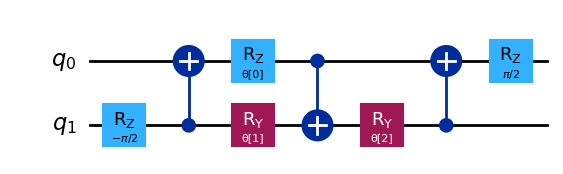

In [2]:
# We now define a two qubit unitary as defined in [3]

def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

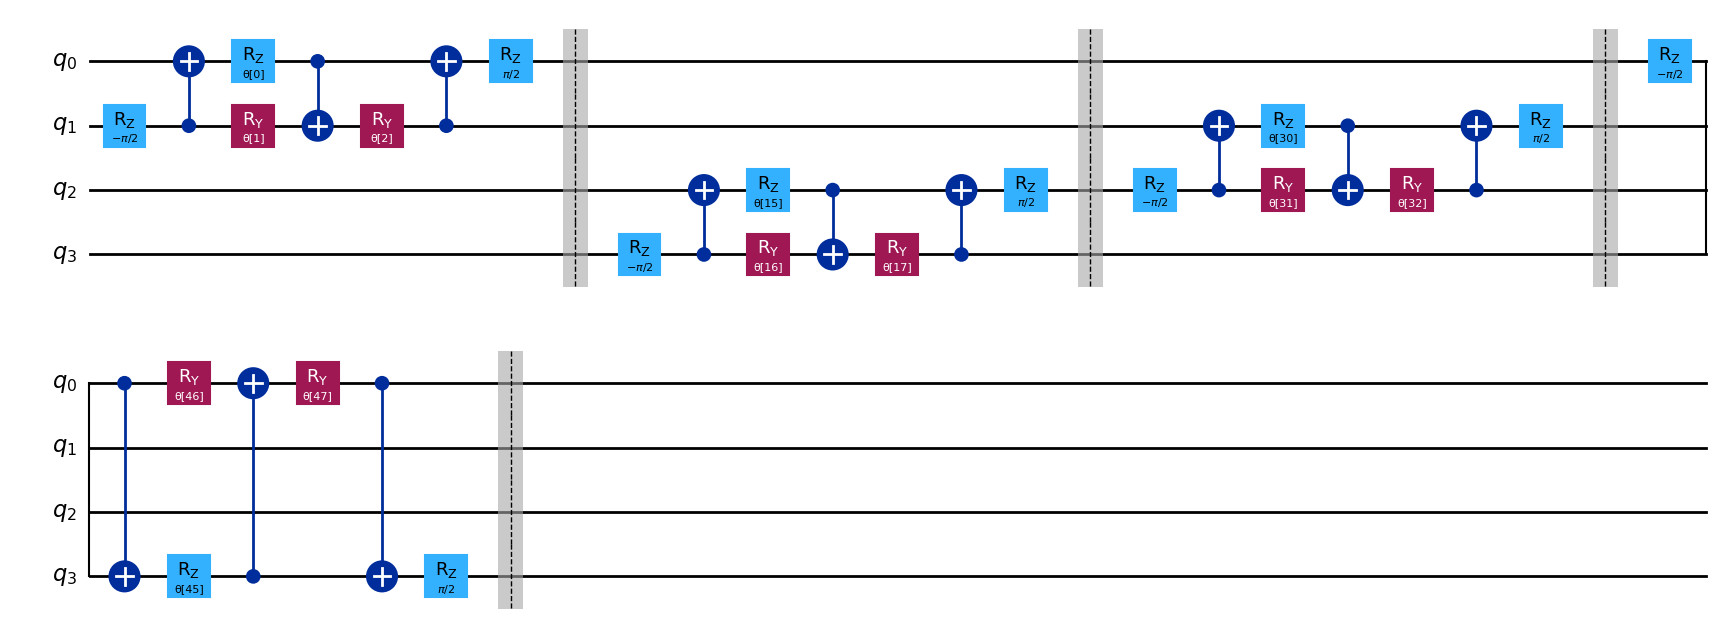

In [3]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 15)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

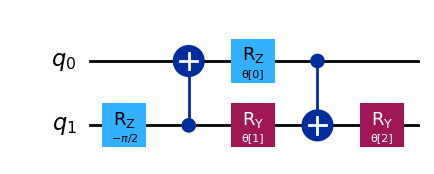

In [4]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

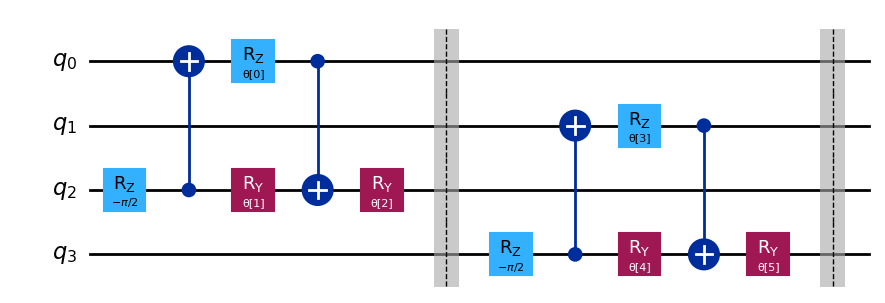

In [5]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

In [6]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/(255.0/np.pi), x_test[..., np.newaxis]/(255.0/np.pi)
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

2024-12-04 11:47:41.556301: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733341661.572382   20383 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733341661.577001   20383 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 11:47:41.592625: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of original training examples: 60000
Number of original test examples: 10000


In [7]:
a = 3
b = 4
c = 5
d = 6
def filter_abcd(x, y):
    keep = (y == a) | (y == b) | (y == c) | (y == d)
    x, y = x[keep], y[keep]
    return x,y

In [8]:
x_train, y_train = filter_abcd(x_train, y_train)
x_test, y_test = filter_abcd(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 23312
Number of filtered test examples: 3842


6


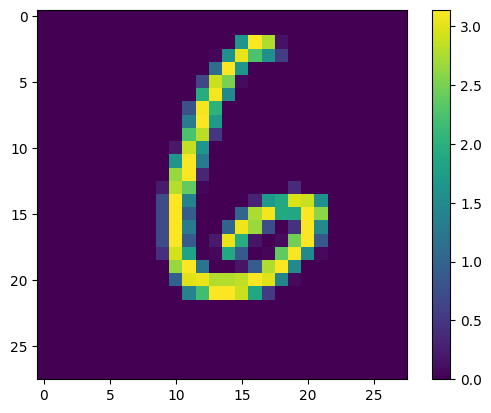

In [9]:
img = 13
print(y_train[img])
plt.imshow(x_train[img, :, :, 0])
plt.colorbar()

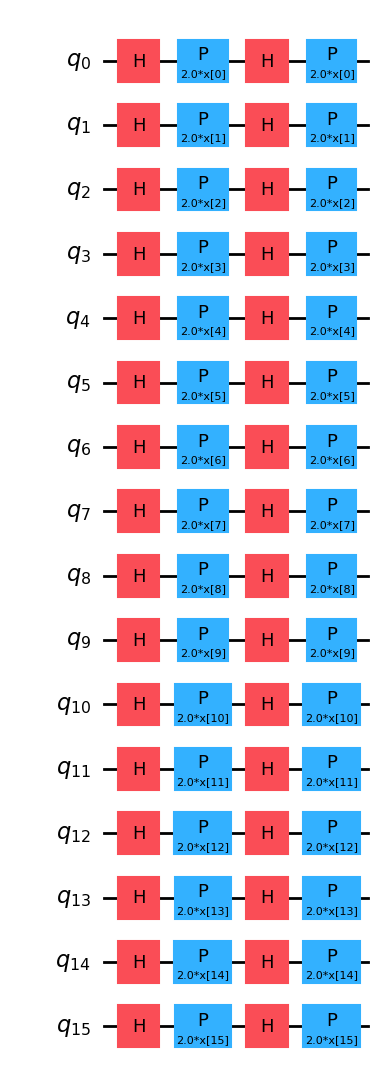

In [10]:
# Feature Map Instantiation
feature_map = ZFeatureMap(16)
feature_map.decompose().draw("mpl")

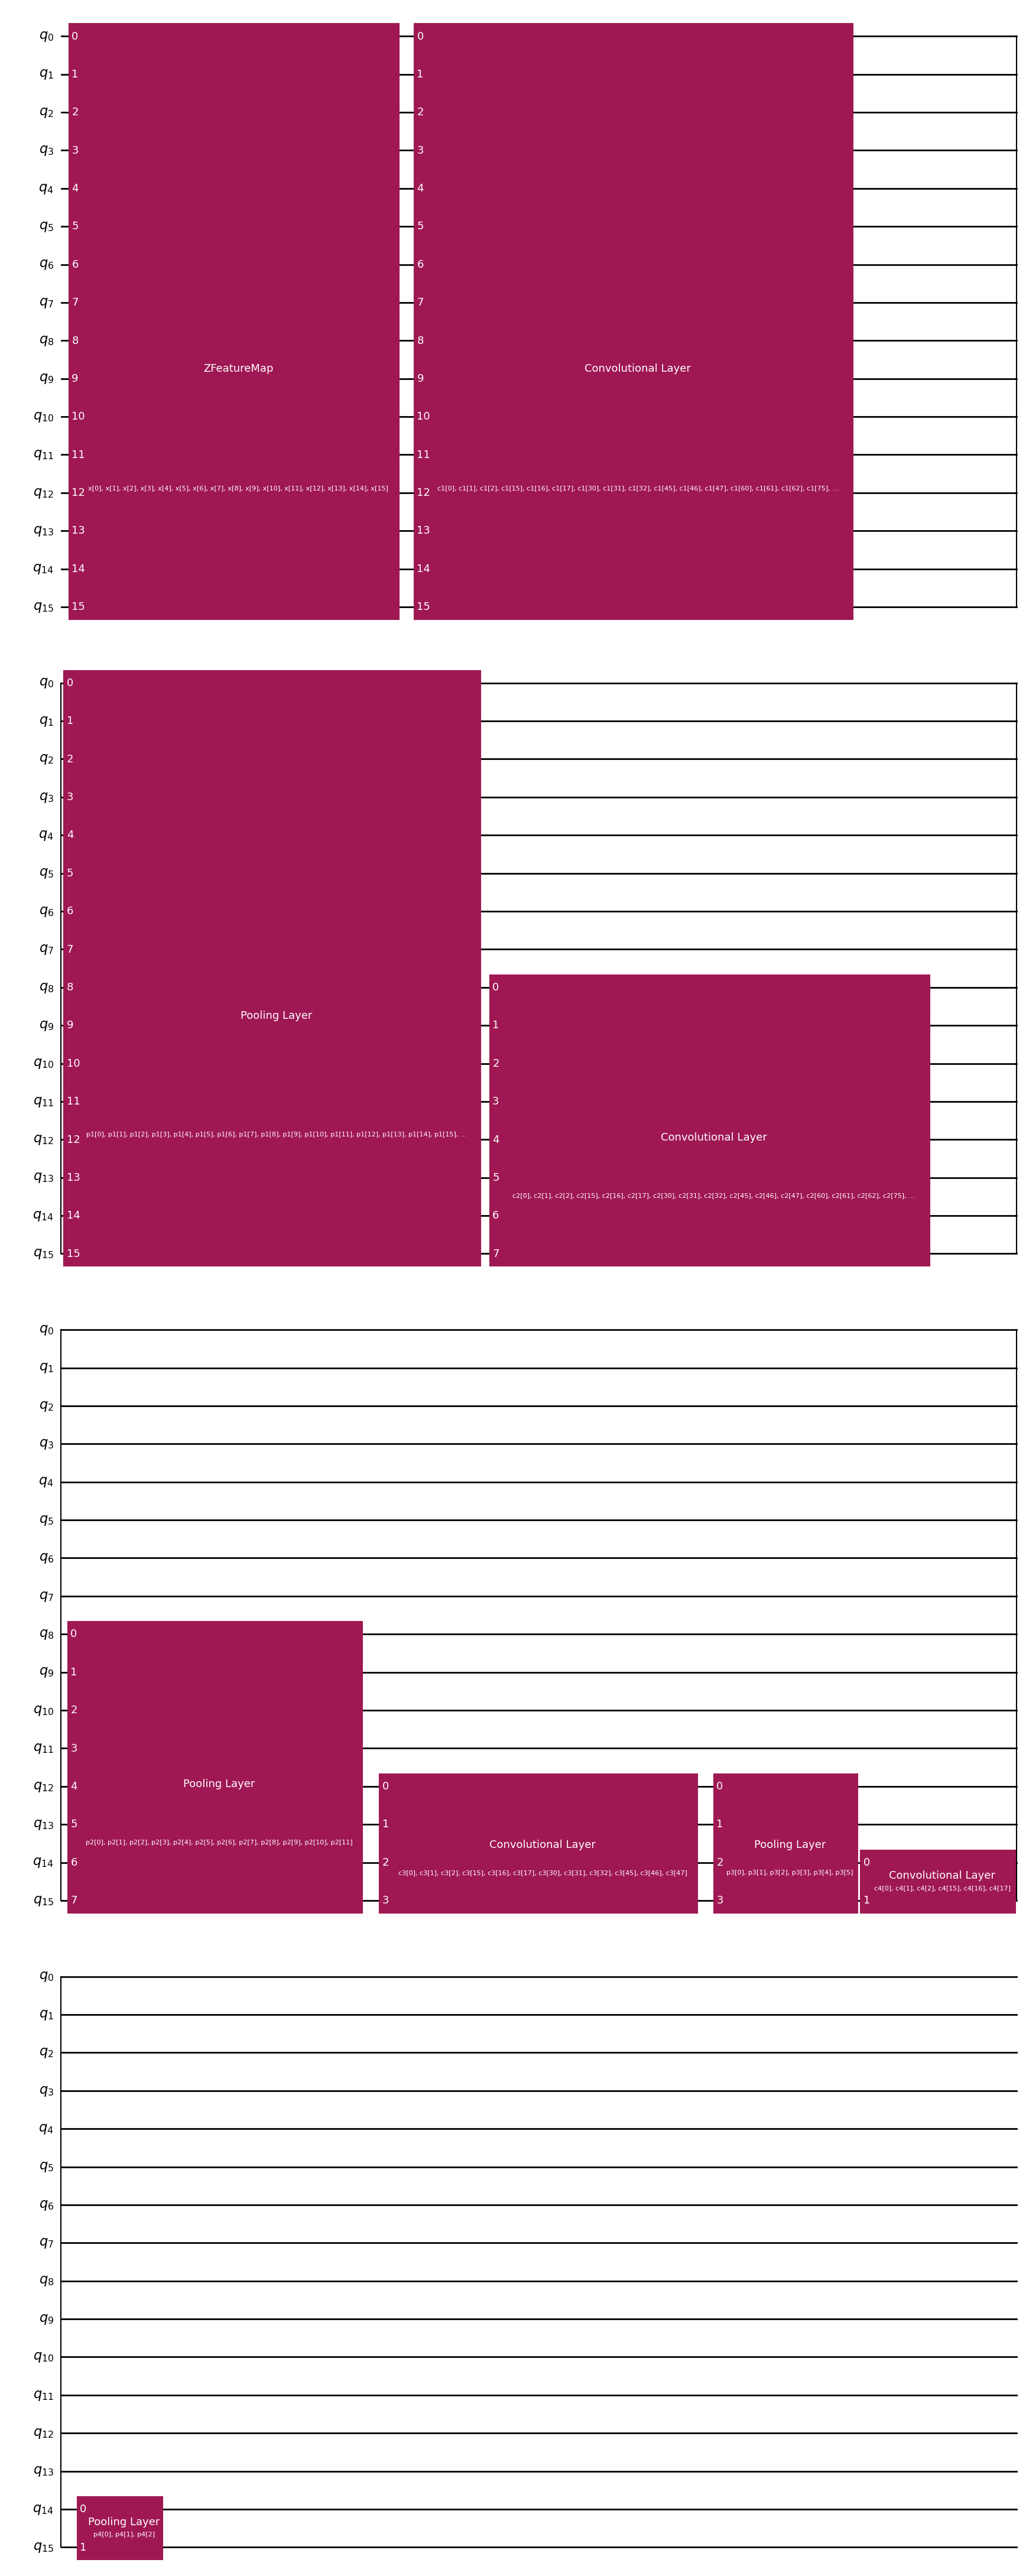

In [11]:
# Ansatz Instantiation
from qiskit import ClassicalRegister, QuantumRegister
q_reg = QuantumRegister(16, "q_reg")
ansatz = QuantumCircuit(q_reg, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(16, "с1"), list(range(16)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15], "p1"), list(range(16)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(8, "c2"), list(range(8, 16)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p2"), list(range(8, 16)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(4, "c3"), list(range(12, 16)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p3"), list(range(12, 16)), inplace=True)

# Fourth Convolutional Layer
ansatz.compose(conv_layer(2, "c4"), list(range(14, 16)), inplace=True)

# Fourth Pooling Layer
ansatz.compose(pool_layer([0], [1], "p4"), list(range(14, 16)), inplace=True)

# Combining the feature map and ansatz
circuit = QNNCircuit(16)
circuit.feature_map = feature_map
circuit.ansatz = ansatz
display(circuit.draw("mpl"))

In [12]:
x_train_small = tf.image.resize(x_train, (4,4), method = 'area').numpy()
x_test_small = tf.image.resize(x_test, (4,4), method = 'area').numpy()

I0000 00:00:1733341665.862626   20383 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


6


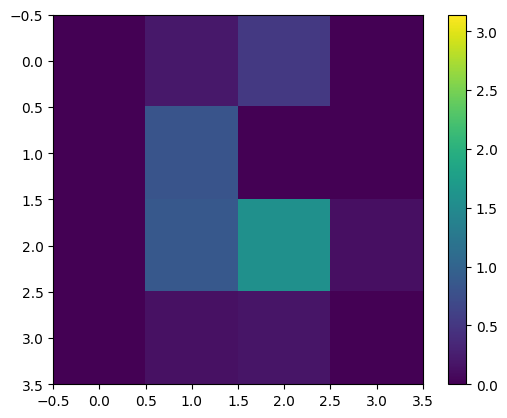

In [13]:
img = 13
print(y_train[img])
plt.imshow(x_train_small[img,:,:,0], vmin=0, vmax=np.pi)
plt.colorbar()

In [14]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
   
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass


    num_uniq_a = sum(1 for value in mapping.values() if len(value) == 1 and a in value)
    num_uniq_b = sum(1 for value in mapping.values() if len(value) == 1 and b in value)
    num_uniq_c = sum(1 for value in mapping.values() if len(value) == 1 and c in value)
    num_uniq_d = sum(1 for value in mapping.values() if len(value) == 1 and d in value)
    num_uniq_all = sum(1 for value in mapping.values() if len(value) >= 2)


    print("Number of unique images:", len(mapping.values()))
    print("Number of unique ", a, "'s: ", num_uniq_a)
    print("Number of unique ", b, "'s: ", num_uniq_b)
    print("Number of unique ", c, "'s: ", num_uniq_c)
    print("Number of unique ", d, "'s: ", num_uniq_d)
    print("Number of unique contradicting labels: ", num_uniq_all)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
   
    return np.asarray(new_x), np.asarray(new_y)

In [15]:
import collections
resized_train_images, train_labels = remove_contradicting(x_train_small, y_train)
resized_test_images, test_labels = remove_contradicting(x_test_small, y_test)

Number of unique images: 23312
Number of unique  3 's:  6131
Number of unique  4 's:  5842
Number of unique  5 's:  5421
Number of unique  6 's:  5918
Number of unique contradicting labels:  0

Initial number of images:  23312
Remaining non-contradicting unique images:  23312
Number of unique images: 3842
Number of unique  3 's:  1010
Number of unique  4 's:  982
Number of unique  5 's:  892
Number of unique  6 's:  958
Number of unique contradicting labels:  0

Initial number of images:  3842
Remaining non-contradicting unique images:  3842


In [16]:
x_reshaped = []
x1_reshaped = []

for g in resized_train_images:
    x_reshaped.append(g.reshape(1,16))

for g in resized_test_images:
    x1_reshaped.append(g.reshape(1,16))

final_x = []
final_x1 = []

for entry in x_reshaped:
    final_x.append(entry[0])

for entry in x1_reshaped:
    final_x1.append(entry[0])

# Easier to work with names
x = final_x
y = train_labels
x1 = final_x1
y1 = test_labels

# Setting labels to 0 or 1 to properly process.
y_temp = []
y1_temp = []

for entry in y:
    if entry == a:
        y_temp.append(0)
    elif entry == b:
        y_temp.append(1)
    elif entry == c:
        y_temp.append(2)
    elif entry == d:
        y_temp.append(3)
y=y_temp

for entry in y1:
    if entry == a:
        y1_temp.append(0)
    elif entry == b:
        y1_temp.append(1)
    elif entry == c:
        y1_temp.append(2)
    elif entry ==d:
        y1_temp.append(3)
y1=y_temp

x = np.asarray(final_x)
y = np.asarray(y)
x1 = np.asarray(final_x1)
y1 = np.asarray(y1)

# Limiting training dataset to lower training time.
x = x[0:2000]
y = y[0:2000]
x1 = x1[0:2000]
y1 = y1[0:2000]

print(x)
print(y)

[[0.         0.19058241 0.5850729  ... 1.2083628  0.15663964 0.        ]
 [0.0359542  0.         0.04701703 ... 0.         0.54685587 0.        ]
 [0.         0.26902792 0.86968946 ... 1.3765682  0.4684103  0.        ]
 ...
 [0.         0.11213688 0.07542839 ... 0.43094754 0.240868   0.        ]
 [0.         0.34621632 0.8905579  ... 1.0011863  0.3263535  0.        ]
 [0.01910853 0.34470776 0.01131426 ... 0.         1.1263974  0.        ]]
[2 1 0 ... 1 0 0]


In [17]:
# Helper Functions to fix up data
def count(y):
    counta = 0
    countb = 0
    countc = 0
    countd = 0
    for i in range(len(y)):
        if y[i] == 0:
            counta+=1
        elif y[i] == 1:
            countb+=1
        elif y[i] == 2:
            countc+=1
        elif y[i] == 3:
            countd+=1
    return(counta, countb, countc, countd)

def balance_lists(x, y, max_count):
    """Balances two lists x and y based on the values in y (0 or 1)."""
    
    x_balanced = []
    y_balanced = []
    count0 = 0
    count1 = 0
    count2 = 0
    count3 = 0

    for i in range(len(y)):
        if y[i] == 0:
            if count0 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count0 += 1
        elif y[i] == 1:
            if count1 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count1 += 1
        elif y[i] == 2:
            if count2 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count2 += 1
        elif y[i] == 3:
            if count3 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count3 += 1
    return x_balanced, y_balanced

def shuffle(arr1, arr2):
    assert len(arr1) == len(arr2)
    p = np.random.permutation(len(arr1))
    return arr1[p], arr2[p]

In [18]:
# Further Data Cleaning Using Helper Functions
nums = count(y)
print("original:", nums)
max_count = min(nums)
print("max_count =", max_count)
x,y = balance_lists(x, y, max_count)

print("balanced:", count(y))

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)
objective_func_vals = []

x,y = shuffle(x,y)
print("shuffled:", count(y))

print("final:", x)
print(y)

original: (502, 545, 442, 511)
max_count = 442
balanced: (442, 442, 442, 442)
shuffled: (442, 442, 442, 442)
final: [[0.         0.17197675 0.6441585  ... 0.39599904 0.50034165 0.        ]
 [0.         0.15764534 0.16342819 ... 0.         0.5521358  0.        ]
 [0.         0.         0.         ... 0.         0.4394961  0.        ]
 ...
 [0.         0.         0.         ... 0.6177586  0.08246837 0.        ]
 [0.24237658 0.72084403 0.02916565 ... 0.21647951 1.3305569  0.28838786]
 [0.         0.2293023  1.1153345  ... 0.50210166 0.3308792  0.        ]]
[2 1 1 ... 2 0 2]


In [19]:
y_temp = []
y1_temp = []

for entry in y:
    if entry == 0:
        y_temp.append([-1,-1])
    elif entry == 1:
        y_temp.append([-1,1])
    elif entry == 2:
        y_temp.append([1,-1])
    elif entry == 3:
        y_temp.append([1,1])
y=np.asarray(y_temp)

for entry in y1:
    if entry == 0:
        y1_temp.append([-1,-1])
    elif entry == 1:
        y1_temp.append([-1,1])
    elif entry == 2:
        y1_temp.append([1,-1])
    elif entry == 3:
        y1_temp.append([1,1])
y1=np.asarray(y_temp)

In [20]:
print(y[:100])
print(y1[:100])

[[ 1 -1]
 [-1  1]
 [-1  1]
 [ 1  1]
 [ 1  1]
 [-1  1]
 [-1 -1]
 [-1  1]
 [-1  1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1  1]
 [ 1  1]
 [-1  1]
 [ 1 -1]
 [-1 -1]
 [ 1 -1]
 [-1 -1]
 [ 1  1]
 [-1  1]
 [-1  1]
 [ 1 -1]
 [-1  1]
 [-1 -1]
 [ 1  1]
 [ 1  1]
 [ 1 -1]
 [ 1 -1]
 [ 1 -1]
 [ 1 -1]
 [ 1 -1]
 [ 1 -1]
 [-1 -1]
 [-1  1]
 [-1  1]
 [-1 -1]
 [ 1  1]
 [ 1  1]
 [-1 -1]
 [-1  1]
 [ 1 -1]
 [-1  1]
 [-1  1]
 [ 1 -1]
 [-1  1]
 [-1  1]
 [-1  1]
 [-1  1]
 [ 1 -1]
 [-1  1]
 [-1  1]
 [-1 -1]
 [ 1  1]
 [ 1 -1]
 [-1  1]
 [-1  1]
 [-1 -1]
 [ 1  1]
 [ 1  1]
 [-1 -1]
 [-1  1]
 [ 1 -1]
 [ 1  1]
 [-1  1]
 [ 1  1]
 [-1  1]
 [ 1 -1]
 [-1  1]
 [ 1  1]
 [ 1  1]
 [ 1 -1]
 [-1 -1]
 [ 1 -1]
 [-1  1]
 [-1 -1]
 [ 1 -1]
 [-1 -1]
 [-1 -1]
 [ 1 -1]
 [-1  1]
 [-1 -1]
 [-1 -1]
 [ 1 -1]
 [-1 -1]
 [ 1 -1]
 [-1  1]
 [ 1  1]
 [-1  1]
 [ 1 -1]
 [ 1  1]
 [-1 -1]
 [-1  1]
 [ 1  1]
 [-1 -1]
 [ 1 -1]
 [-1  1]
 [ 1 -1]
 [ 1  1]
 [-1  1]]
[[ 1 -1]
 [-1  1]
 [-1  1]
 [ 1  1]
 [ 1  1]
 [-1  1]
 [-1 -1]
 [-1  1]
 [-1  1]
 [-1 -1]
 [-1 -1]


In [21]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    print("objective function value", objective_func_vals)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [22]:
# Check GPU Availability
from qiskit_aer import AerSimulator
print(AerSimulator().available_devices())
print(AerSimulator().available_methods())

('CPU', 'GPU')
('automatic', 'statevector', 'density_matrix', 'stabilizer', 'matrix_product_state', 'extended_stabilizer', 'unitary', 'superop', 'tensor_network')


In [64]:
from qiskit_aer.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.utils import algorithm_globals
algorithm_globals.random_seed = 65

sampler = Estimator()
sampler.set_options(device='GPU')
sampler.set_options(method="statevector")

num_qubits = 16

observable_z15 = SparsePauliOp.from_sparse_list([("Z", [15], 1)], num_qubits=num_qubits)
observable_z16 = SparsePauliOp.from_sparse_list([("Z", [14], 1)], num_qubits=num_qubits)
observables = [observable_z15, observable_z16]

estimator = EstimatorQNN(
    estimator = sampler,
    circuit = circuit,
    observables = observables,
    input_gradients = True,
)

# Checking Data Forward Result
weights = algorithm_globals.random.random(estimator.num_weights)
estimator.forward(input_data = x1[:20], weights = weights)

/tmp/ipykernel_20383/1774759899.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  estimator = EstimatorQNN(
/tmp/ipykernel_20383/1774759899.py:16: UserWarning: No number of qubits was not specified (None) and was retrieved from `circuit` (16). If `circuit` is transpiled, this may cause unstable behaviour.
  estimator = EstimatorQNN(


array([[ 0.046875  , -0.00195312],
       [-0.01367188,  0.        ],
       [ 0.00585938, -0.01171875],
       [-0.05859375,  0.03515625],
       [-0.07617188, -0.04492188],
       [-0.00976562,  0.01367188],
       [ 0.05078125, -0.00976562],
       [ 0.02929688,  0.015625  ],
       [ 0.01367188,  0.02539062],
       [-0.00585938, -0.02539062],
       [-0.01953125, -0.04492188],
       [ 0.02148438, -0.0625    ],
       [ 0.00195312, -0.01953125],
       [-0.0625    ,  0.01171875],
       [ 0.01953125, -0.02539062],
       [-0.0703125 , -0.0078125 ],
       [ 0.01367188,  0.00195312],
       [ 0.        ,  0.01367188],
       [ 0.10546875,  0.01367188],
       [ 0.01757812,  0.0078125 ]])

In [65]:
from qiskit_machine_learning.connectors import TorchConnector
from torch.nn import MSELoss, Module
from torch.optim import Adam
qnn = TorchConnector(estimator, weights)

In [66]:
class Model(Module): # Simplified
    def __init__(self, qnn_module):
        super().__init__()
        self.qnn_module = qnn_module

    def forward(self, x):
        x = self.qnn_module(x)
        return x

model = Model(qnn)
loss_func = MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)
model.train() # Put model into training mode

Model(
  (qnn_module): TorchConnector()
)

In [ ]:
from torch.utils.data import Dataset, DataLoader
dataset = CustomDataset(x, y)
batch_size = 32
train_loader = DataLoader(x, batch_size=batch_size, shuffle=True)
for epoch in range(2):
    total_loss = []
    for batch_idx, (data, target, *extra) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)
        output = model(data)  # Data now directly goes to the QNN
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())

    avg_loss = sum(total_loss) / len(total_loss)
    print(f"Epoch {epoch+1}/100, Loss: {avg_loss}")

/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (2) must match the size of tensor b (16) at non-singleton dimension 0

In [57]:
# Classifier to forward and backward pass data (default loss = squared_error)
classifier = NeuralNetworkClassifier(
    estimator,
    optimizer=COBYLA(maxiter=100),
    callback=callback_graph,
    warm_start=True,
    one_hot = True
)

In [51]:
# %%time
# # Checkpoint Arrays
# cpt_weights = []
# cpt_train = []
# cpt_test = []

# for i in range(3):
#     # Shuffling
#     # shuffle(x,y)
#     print(x,y)

#     # Run Fit
#     classifier.fit(x, y)

#     # Checking checkpoint data for overfitting/underfitting signs
#     cpt_weights.append(classifier.weights)
#     cpt_train.append(f"{np.round(100 * classifier.score(x, y), 2)}%")
#     cpt_test.append(f"{np.round(100 * classifier.score(x1, y1), 2)}%")

#     # Logs to monitor performance
#     print(cpt_weights, cpt_train, cpt_test)

# # Saving predicted values for test data to display later
# y_predict = classifier.predict(x1)

In [58]:
print(x.shape,y.shape)

(188, 16) (188, 2)


objective function value [0.9943851470947266, 1.0157505035400392, 0.9829917907714844, 1.0045612335205079, 1.032958984375, 0.9909656524658204, 1.0121971130371095, 0.8986030578613281, 0.8816883087158203, 0.8964454650878906, 1.0335052490234375, 0.9206844329833984, 0.9313461303710937, 0.9055347442626953, 0.8972011566162109, 0.9044727325439453, 0.8004436492919922, 0.7353572845458984, 0.7022327423095703, 0.8022724151611328, 0.7473499298095703, 0.7437286376953125, 0.8975654602050781, 0.897005844116211, 0.7379280090332031, 0.8767860412597657, 0.8764633178710938, 0.7452510833740235, 0.7085880279541016, 0.7156764984130859, 0.750979232788086, 0.8710517883300781, 0.8103111267089844, 0.7361862182617187, 0.7393783569335938, 0.7467433929443359, 0.7259025573730469, 0.7198657989501953, 0.7379825592041016, 0.7218276977539062, 0.7363262176513672, 0.7364612579345703, 0.7590724945068359, 0.7206222534179687, 0.7673110961914062, 0.7223316192626953, 0.7461761474609375, 0.7229969024658203, 0.7161651611328125, 

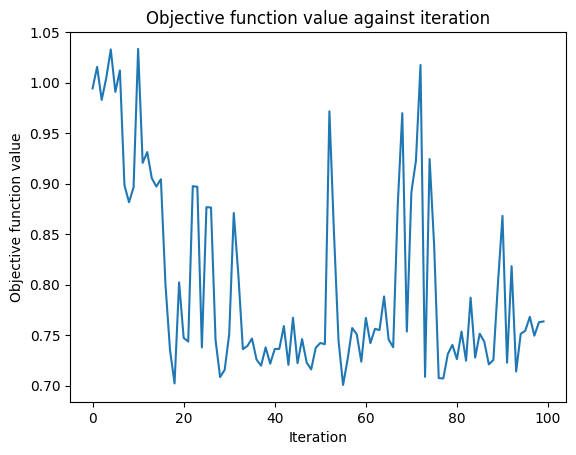

CPU times: user 1min 33s, sys: 1.19 s, total: 1min 34s
Wall time: 28.8 s


In [60]:
%%time
# Checkpoint Arrays
cpt_weights = []
cpt_train = []
cpt_test = []

# for i in range(3):
#     # Shuffling
#     # shuffle(x,y)
#     print(x,y)

#     # Run Fit
#     classifier.fit(x, y)

#     # Checking checkpoint data for overfitting/underfitting signs
#     cpt_weights.append(classifier.weights)
#     cpt_train.append(f"{np.round(100 * classifier.score(x, y), 2)}%")
#     cpt_test.append(f"{np.round(100 * classifier.score(x1, y1), 2)}%")

#     # Logs to monitor performance
#     print(cpt_weights, cpt_train, cpt_test)

classifier.fit(x[:10], y[:5])




In [61]:
print((f"{np.round(100 * classifier.score(x, y), 2)}%"))
print((f"{np.round(100 * classifier.score(x, y), 2)}%"))
# Saving predicted values for test data to display later
y_predict = classifier.predict(x1)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [ ]:
print(cpt_weights, cpt_train, cpt_test)

[] [] []


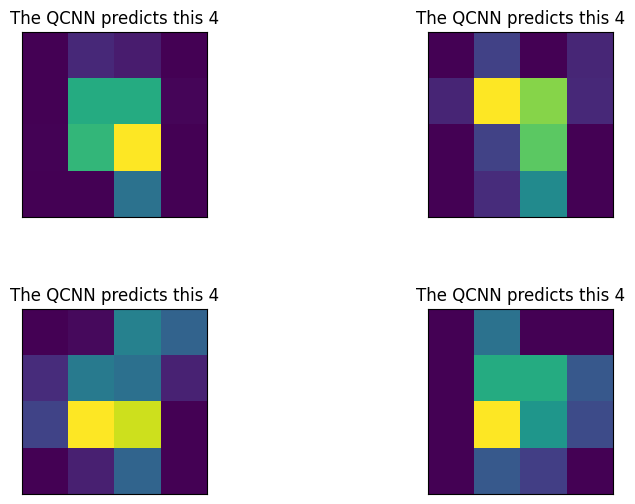

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(x1[i].reshape(4, 4), aspect="equal")
    if y_predict[i] == 0:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 3")
    if y_predict[i] == 1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this 4")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [ ]:
# Printing Actual Data
y1[:1000]

[(-1, 1),
 (-1, 1),
 (1, -1),
 (-1, 1),
 (-1, -1),
 (-1, 1),
 (1, 1),
 (-1, 1),
 (1, -1),
 (-1, -1),
 (1, 1),
 (1, -1),
 (1, 1),
 (1, -1),
 (-1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (-1, 1),
 (-1, 1),
 (1, -1),
 (1, -1),
 (1, -1),
 (-1, -1),
 (-1, -1),
 (-1, 1),
 (1, 1),
 (-1, -1),
 (1, 1),
 (-1, -1),
 (-1, 1),
 (-1, 1),
 (1, -1),
 (-1, -1),
 (1, -1),
 (-1, 1),
 (1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (1, 1),
 (1, -1),
 (-1, -1),
 (-1, 1),
 (1, -1),
 (1, -1),
 (-1, -1),
 (-1, -1),
 (-1, -1),
 (1, -1),
 (-1, -1),
 (-1, -1),
 (-1, -1),
 (1, -1),
 (1, 1),
 (-1, -1),
 (1, -1),
 (-1, -1),
 (-1, -1),
 (1, 1),
 (1, 1),
 (-1, -1),
 (1, 1),
 (-1, -1),
 (1, 1),
 (-1, 1),
 (1, -1),
 (1, -1),
 (-1, -1),
 (-1, 1),
 (-1, 1),
 (-1, -1),
 (-1, -1),
 (-1, 1),
 (-1, -1),
 (-1, 1),
 (1, -1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, -1),
 (1, -1),
 (1, -1),
 (-1, 1),
 (-1, -1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, -1),
 (-1, -1),
 (1, 1),
 (1, -1),
 (1, -1),
 (-1, -1),
 (-1, -1),
 (1, -1),
 (1

In [ ]:
# Printing Predicted Data for Comparision
y_predict[:1000]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [ ]:
# Printing Weights for Backup Checkpoint
weights = classifier.weights
weights

QiskitMachineLearningError: 'The model has not been fitted yet'

In [ ]:
# Saving Model
classifier.save("Classifier2ClassCircuit1_2QB(4)")